In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


# Model Setting

In [2]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNetdl():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Training dataset

In [3]:
# auto. choose CPU or GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Function to load CIFAR-10 dataset
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the directory containing CIFAR-10 batches
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load metadata (labels)
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]

# Load training data
train_data = []
train_labels = []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']

train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Convert to HWC format
train_labels = np.array(train_labels)

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.2,scale=(0.02, 0.1),value=1.0, inplace=False)
])

# Convert to TensorDataset and apply transformations
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=transform)

# Function to display the first image
# def show_first_image(images, labels, label_names):
#     first_image = images[0]  # Get the first image
#     first_label = labels[0]  # Get the first label

#     # Display the image
#     plt.imshow(first_image)
#     plt.title(f"Label: {label_names[first_label]}")
#     plt.axis('off')
#     plt.show()

# # Call the function to display the first image
# show_first_image(train_data, train_labels, label_names)

Using device: cuda


# Validation dataset

In [4]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),   # Convert [0,255] to [0.0,1.0]
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

batch_test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
val_images = batch_test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
val_labels = np.array(batch_test_dict[b'labels'])

val_dataset = CustomCIFAR10Dataset(val_images, val_labels, transform=test_transform)

# # Function to display the first image of a dataset
# def show_first_image(images, labels, label_names, transform=None):
#     first_image = images[0]  # Get the first image
#     first_label = labels[0]  # Get the first label

#     # Apply transformation if provided
#     if transform:
#         first_image = transform(first_image)

#     # Denormalize the image for visualization
#     mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
#     std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)
#     first_image = first_image * std + mean

#     # Convert from tensor to numpy and transpose to HWC format
#     first_image = first_image.permute(1, 2, 0).numpy()

#     # Display the image
#     plt.imshow(first_image)
#     plt.title(f"Label: {label_names[first_label]}")
#     plt.axis('off')
#     plt.show()

# # Call the function to display the first image of the validation dataset
# show_first_image(val_images, val_labels, label_names, transform=test_transform)

# Test dataset

In [5]:
# Load test dataset
cifar_test_path = '/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data']

# Convert test dataset to Tensor
test_dataset = [(test_transform(img),) for img in test_images]

# def show_first_test_image(test_images, transform=None):
#     first_image = test_images[9]  # Get the first image

#     # Apply transformation if provided
#     if transform:
#         first_image = transform(first_image)

#     # Denormalize the image for visualization
#     mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
#     std = torch.tensor([0.247, 0.243, 0.261]).view(3, 1, 1)
#     first_image = first_image * std + mean

#     # Convert from tensor to numpy and transpose to HWC format
#     first_image = first_image.permute(1, 2, 0).numpy()

#     # Display the image
#     plt.imshow(first_image)
#     plt.axis('off')
#     plt.show()

# # Call the function to display the first image of the test dataset
# show_first_test_image(test_images, transform=test_transform)

In [6]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Train function
def train_model(model, train_loader, val_loader, epochs=50):
    # criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    # optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4) #change lr
    # scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
    # scheduler = StepLR(optimizer, step_size=6, gamma=0.85)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step()
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # Plot Losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='red')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss & Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy', color='green')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Train Accuracy & Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,432
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]           2,048
       BatchNorm2d-8           [-1, 64, 32, 32]             128
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
       BasicBlock-14           [-1, 64,

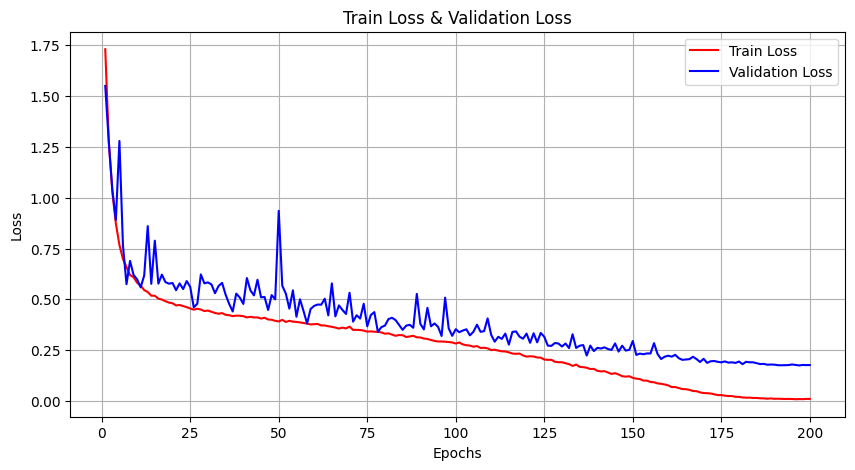

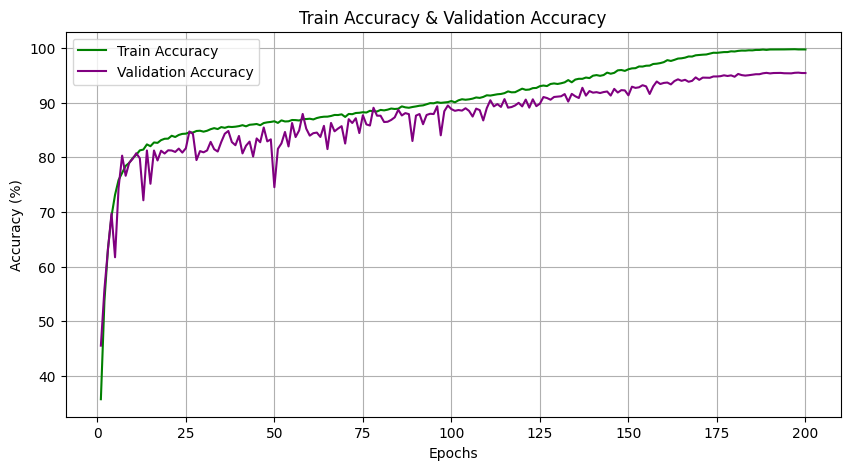

Submission1 file saved.
   ID  Labels
0   0       6
1   1       1
2   2       8
3   3       6
4   4       9
5   5       7
6   6       0
7   7       2
8   8       9
9   9       5


In [7]:
# put models to devices (CPU/GPU)
model = ResNetdl()

model.to(device)

# Print the number of parameters
from torchsummary import summary
summary(model, (3, 32, 32))

# Train the model
train_model(model, train_loader, val_loader, epochs=200) #change epoch

# Generate submission file
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)
        outputs = model(images) 
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/kaggle/working/submission1.csv', index=False)
print("Submission1 file saved.")
print(submission.head(10))